# Guided mode expansion of a PhC slab with a horizontal (xy) symmetry plane

In this example we apply `legume` to calculate the bands of a PhC slab with a horizontal (xy) mirror plane, and we demonstrate how the bands can be separated according to reflection symmetry $\sigma_{xy}$. This example is related to Sec. 2.3 of the CPC paper.

The structure parameters are those of Ch. 8, Fig. 2(b) of [Molding the Flow of Light](http://ab-initio.mit.edu/book/) , and we focus on how to achieve separation with respect to $\sigma_{xy}$ by choosing the indices of the guided modes in the expansion.

Install the latest version of legume

In [ ]:
import sys
sys.path.append("/content/legume")
import legume
print(f"Version of the imported legume : {legume.__version__}")

import numpy as np
import matplotlib.pyplot as plt

Version of the imported legume : 1.0.1


Here we consider an xy-symmetric PhC slab, i.e., a slab that is symmetric with respect to mirror reflection in the xy plane. We separate the two polarizations as (see Sec. 2.3, Table 1 of the CPC paper):

* $xy$-even or $\sigma_{xy}=+1$ (or TE-like): we must use guided modes $\alpha=0, 3, 4, 7, ...$ in the basis
* $xy$-odd or $\sigma_{xy}=-1$ (or TM-like): we must use guided modes $\alpha=1, 2, 5, 6, ...$ in the basis

In PhC literature, $xy$-even modes are often called TE-like, while $xy$-odd modes are often called TM-like, where the terminology is borrewed from the 2D case. We prefer to avoid this terminology when using `legume`, because we reserve the words `TE` or `TM` for the polarizations of the guided modes of the effective waveguide, which are defined with respect to a vertical mirror plane.

In [ ]:
D = 0.6         # slab thickness in units of a
r = 0.3        # hole radius in units of a
eps_c = 1.0     # permittivity of circular hole
eps_b = 12.0    # background permittivity of slab
eps_lower, eps_upper = 1, 1  # permittivities of lower and upper claddings

lattice = legume.Lattice('hexagonal')
phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
phc.add_layer(d=D, eps_b=eps_b)
phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=r, x_cent=0., y_cent=0))

gme = legume.GuidedModeExp(phc, gmax=5, truncate_g='abs')

Number of reciprocal lattice vectors in the expansion: npw =  61


In [ ]:
# Run the plane-wave expansion for the two separate symmetries and store the bands
path = lattice.bz_path(['G', 'M', 'K', 'G'], [30, 20, 30])
numeig, verbose = 20, True

gme.run(kpoints=path['kpoints'], gmode_inds=[0, 3], numeig=numeig, verbose=True, compute_im=False)
freqs_xyeven = gme.freqs

nkappa, nfreq = freqs_xyeven.shape[0], freqs_xyeven.shape[1]

gme.run(kpoints=path['kpoints'], gmode_inds=[1, 2], numeig=numeig, verbose=True, compute_im=False)
freqs_xyodd = gme.freqs


11.251s total time for real part of frequencies, of which
  8.812s (78%) for guided modes computation using the gmode_compute='exact' method
  0.000s (0%) for inverse matrix of Fourier-space permittivity
  0.797s (7%) for matrix diagionalization using the 'eigh' solver
  1.282s (11%) for creating GME matrix
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
nkappa, nfreq =  81 20
10.478s total time for real part of frequencies, of which
  8.101s (77%) for guided modes computation using the gmode_compute='exact' method
  0.000s (0%) for inverse matrix of Fourier-space permittivity
  0.735s (7%) for matrix diagionalization using the 'eigh' solver
  1.260s (12%) for creating GME matrix
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


Calculate the cladding light line for the plot (the one corresponding to the higher permittivity, but here the two claddings are identical)

In [ ]:
eps_clad = [gme.phc.claddings[0].eps_avg, gme.phc.claddings[-1].eps_avg]
vec_LL = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(max(eps_clad))

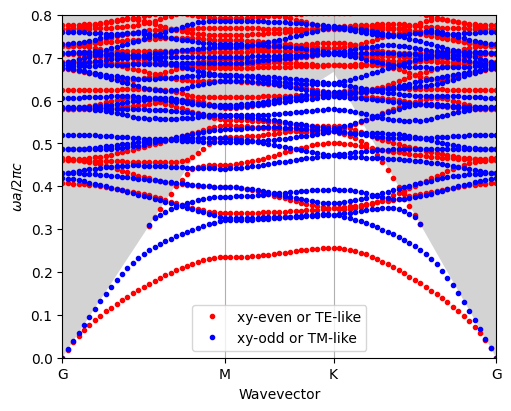

In [ ]:
# Plot the results
# we make the plots explicitly, without using legume.viz, in order to put the legends
markersize = 3
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5, 4))
kappa = range(nkappa)
for j in range(nfreq):
  if (j == 0):
    plt.plot(kappa, freqs_xyeven[:,j], 'ro', label='xy-even or TE-like', markersize=markersize)
    plt.plot(kappa, freqs_xyodd[:,j], 'bo', label='xy-odd or TM-like', markersize=markersize)
  else:
    plt.plot(kappa, freqs_xyeven[:,j], 'ro', markersize=markersize)
    plt.plot(kappa, freqs_xyodd[:,j], 'bo', markersize=markersize)
ax.set_ylim([0, 0.8])
ax.set_xlim([0, gme.freqs.shape[0]-1])
ax.set_xlabel("Wavevector")
ax.set_ylabel("$\omega a/2\pi c$")
plt.legend(loc='lower center')

conecolor='lightgrey'
ax.fill_between(kappa, vec_LL,  max(100, vec_LL.max(), gme.freqs[:].max()),
                facecolor=conecolor,        zorder=0)

# The `path` dict provides some useful functionality for labeling of the BZ path
plt.xticks(path['indexes'], path['labels'])
ax.xaxis.grid('True')


The bands are a bit complicated, aren't they? This is because we are looking at the modes both below and above the light cone. Moreover, the slab is relatively thick and there are second-order guided modes below the light cone.

To better understand the second point, we compare the band dispersion in the PhC with those of the effective waveguide.

In [ ]:
# Run the plane-wave expansion for the two separate polarizations and store the bands
only_gmodes = True  # this keyword parameter select to calculate the guided modes of the effective waveguids
numeig, verbose = 20, False

gme = legume.GuidedModeExp(phc, gmax=5, truncate_g='abs') # we have to re-iniitialize the gme object to avoid errors
gme.run(kpoints=path['kpoints'], gmode_inds=[0, 3], numeig=numeig, verbose=verbose, compute_im=False, only_gmodes=only_gmodes)
freqs_xyeven_gmodes = gme.freqs
nkappa, nfreq = freqs_xyeven_gmodes.shape[0], freqs_xyeven_gmodes.shape[1]

gme = legume.GuidedModeExp(phc, gmax=5, truncate_g='abs')
gme.run(kpoints=path['kpoints'], gmode_inds=[1, 2], numeig=numeig, verbose=verbose, compute_im=False, only_gmodes=only_gmodes)
freqs_xyodd_gmodes = gme.freqs

nkappa, nfreq =  81 20


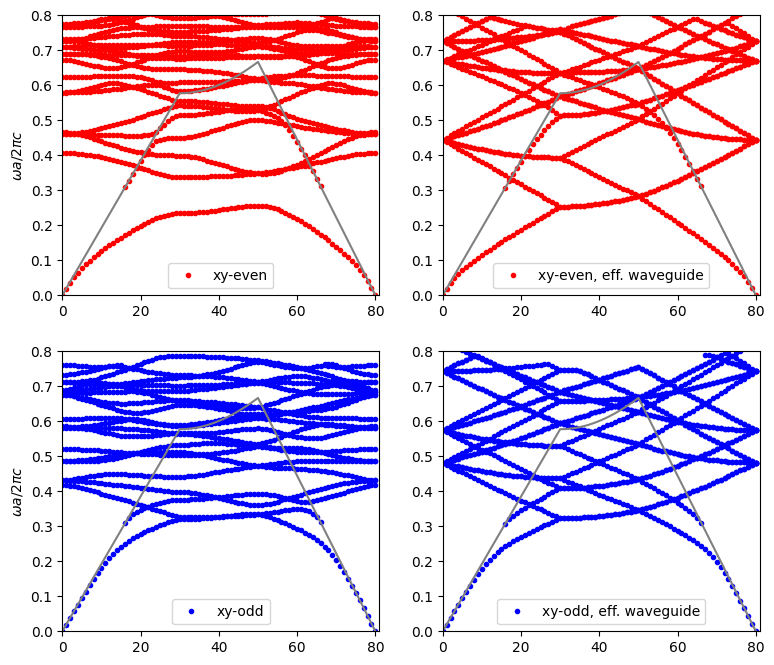

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (9, 8))
ymin, ymax = 0, 0.8

markersize = 3
#fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5, 4))
kappa = range(nkappa)
for j in range(nfreq):
  if (j == 0):
    ax[0,0].plot(kappa, freqs_xyeven[:,j], 'ro', label='xy-even', markersize=markersize)
    ax[1,0].plot(kappa, freqs_xyodd[:,j] , 'bo', label='xy-odd' , markersize=markersize)
    ax[0,1].plot(kappa, freqs_xyeven_gmodes[:,j], 'ro', label='xy-even, eff. waveguide', markersize=markersize)
    ax[1,1].plot(kappa, freqs_xyodd_gmodes[:,j] , 'bo', label='xy-odd, eff. waveguide' , markersize=markersize)
  else:
    ax[0,0].plot(kappa, freqs_xyeven[:,j], 'ro', markersize=markersize)
    ax[1,0].plot(kappa, freqs_xyodd[:,j] , 'bo', markersize=markersize)
    ax[0,1].plot(kappa, freqs_xyeven_gmodes[:,j], 'ro', markersize=markersize)
    ax[1,1].plot(kappa, freqs_xyodd_gmodes[:,j] , 'bo', markersize=markersize)
for i in range(2):
  for j in range(2):
    ax[i,j].plot(kappa, vec_LL, color='grey')
    ax[i,j].set_xlim([0, nkappa])
    ax[i,j].set_ylim([ymin, ymax])
    ax[i,j].legend()
ax[0,0].set_ylabel("$\omega a/2\pi c$")
ax[1,0].set_ylabel("$\omega a/2\pi c$")
plt.legend(loc='lower center')

The final message is: to see whether a photonic bandgap occurs in a PhC slab, we should look at modes *below* and *above* the light cone. And we should keep a sufficient number of guided modes in the basis, to be sure to have all photonic bands in the relevant frequency range.

As a further example, we could calculate the photonic dispersion adding the guided modes one by one in the array gmode_inds, and look at the effect of guided modes of first-order, second-order, ...

(It is not easy to do fancy graphics with PhC slab bands, they cannot be plotted with lines because of broken curves. If you want better plots, try increasing the number of points - wait patiently - then play with markersize.)
